# Step 2: Preprocessing & Classification model
This section will load up the defined settings from the pickles directory and run the machine learning pipeline with the help of the `pycaret` library and save respective data.

In [1]:
%load_ext jupyternotify
# importing all packages needed in this section
import pandas as pd
import os
import sys 

from sklearn.metrics import classification_report
from pycaret.classification import *
from pycaret.containers.models.classification import get_all_model_containers

# utility functions for the experiment
sys.path.append('../src')

from mlflow_manager import MLFlowManager
from tuning_grids import Grids
from utils import getPicklesFromDir, getExperimentConfig, run_pycaret_setup, translate_model_name

# Get global experiment settings
config = getExperimentConfig()
folders = config['folders']
# get a list of all settings for the datasets prepared beforehand
dataset_settings = getPicklesFromDir(folders['settings_dir'])  

<IPython.core.display.Javascript object>

In [2]:
import time

start_time = time.perf_counter()

dataset_settings pickle is saved as follows:
```
"meta_data": meta_dataset,  # contains information about the dataset, including path
"setup_param": setup_param, # contains all the setup parameters for pycaret setup() function
"sdg_param": sdg_param,     # contains all sdg parameters for the CTGAN() function

```

In [3]:
%%notify -m "Step2: Original data models finished!"
run_dataset = config['run_dataset']

for settings in dataset_settings:
        
    if run_dataset is not None and settings['meta']['id'] not in run_dataset:
        # Checks if run_dataset contains dataset_id's
        # if it does, run the experiment only on specified datasets
        continue
        
    # get path
    dataset_path = f"{folders['real_dir']}{settings['meta']['filename']}"
    # run setup function
    s = run_pycaret_setup(dataset_path, settings['setup_param'])
    
    USI = s.get_config('USI')

    
    # Init experiment logging
    experiment_name = f"{settings['meta']['id']}-{settings['meta']['name']}"
    mlflow = MLFlowManager(experiment_name)
    
    logg_tags = {
        'USI': USI,
        'Dataset ID': settings['meta']['id'],
        'Dataset Type': 'original'
    }
    
    mlflow.start_run("Original data models", tags=logg_tags)
    
    # for each defined model in the global config
    # create specified model and tune it
    for ml_model in config['clf']['ml_models']:
        
        model_name = f"{settings['meta']['id']}-{translate_model_name(ml_model)}"
        logg_tags['model']=ml_model
        
        mlflow.start_run(model_name, tags=logg_tags, nested=True)

        # create & tune model
        #model = s.create_model(ml_model)
        
        #Quickfix for efficiency
        all_models = get_all_model_containers(s)
        model = all_models[ml_model].class_def()
        
        tune_grid = Grids.get_tuning_grid(ml_model)
        
        tuned_model = s.tune_model(model, **config['clf']['tuning_param'], custom_grid=tune_grid)
        #Old: tuned_model = s.tune_model(model, **config['clf']['tuning_param'])
        
        # get validation results
        val_df = s.pull()
        val_score = {}
        val_score['Accuracy'] = val_df['Accuracy']['Mean']
        val_score['F1-score'] = val_df['F1']['Mean']
        val_score['AUC']      = val_df['AUC']['Mean']
        val_score['Kappa']    = val_df['Kappa']['Mean']
        val_score['MCC']      = val_df['MCC']['Mean']
        
        # test the model on the holdout-data
        holdout_score = s.predict_model(estimator=tuned_model)
        #metrics =  classification_report(y_true=y_test, y_pred=y_pred, output_dict=True, digits=4)
        #metrics_df = pd.DataFrame(metrics).transpose()
        
        # log parameters     
        mlflow.log_params(tuned_model.get_params())
        # log performance
        mlflow.log_metrics(val_score)
        mlflow.log_score_report_to_html(val_df, "Validation")
        mlflow.log_score_report_to_html(holdout_score, "Holdout")
        # log model
        mlflow.log_model(model=tuned_model)
        
        mlflow.end_run()
        
    # Save model details on the model with best accurracy under the the 'Original data models' run
    best_run = mlflow.get_best_run_by_metric(metric_name='Accuracy')
    
    mlflow.log_params(best_run.data.params)
    mlflow.log_metrics(best_run.data.metrics)
    mlflow.log_tag('model run name', best_run.data.tags['mlflow.runName'])
    mlflow.log_tag('model', best_run.data.tags['model'])
    mlflow.log_tag('model run id', best_run.info.run_id)
    
    mlflow.end_run()          

,Description,Value
0,Session id,6260
1,Target,Outcome
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(614, 9)"
6,Transformed test set shape,"(154, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,None


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7742,0.8420,0.5455,0.7500,0.6316,0.4746,0.4871
1,0.7258,0.8091,0.5000,0.6471,0.5641,0.3689,0.3754
2,0.7419,0.8750,0.5000,0.6875,0.5789,0.3995,0.4100
3,0.6935,0.7023,0.4091,0.6000,0.4865,0.2791,0.2895
4,0.7541,0.7821,0.6190,0.6500,0.6341,0.4491,0.4494
5,0.7377,0.7679,0.5238,0.6471,0.5789,0.3915,0.3961
6,0.7377,0.7595,0.4286,0.6923,0.5294,0.3613,0.3812
7,0.8033,0.8893,0.7143,0.7143,0.7143,0.5643,0.5643
8,0.8197,0.9214,0.5714,0.8571,0.6857,0.5663,0.5891


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8377,0.8804,0.7037,0.8085,0.7525,0.6326,0.6359


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6935,0.7892,0.3182,0.6364,0.4242,0.2458,0.2733
1,0.7581,0.8080,0.6364,0.6667,0.6512,0.4661,0.4664
2,0.8065,0.8580,0.5000,0.9167,0.6471,0.5291,0.5753
3,0.6613,0.6926,0.3182,0.5385,0.4000,0.1852,0.1977
4,0.7213,0.8083,0.5238,0.6111,0.5641,0.3611,0.3634
5,0.7541,0.7500,0.4286,0.7500,0.5455,0.3936,0.4226
6,0.7705,0.8095,0.4762,0.7692,0.5882,0.4411,0.4655
7,0.8361,0.9012,0.7143,0.7895,0.7500,0.6285,0.6302
8,0.7541,0.8940,0.4762,0.7143,0.5714,0.4085,0.4250


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.7597,0.7907,0.6296,0.6667,0.6476,0.4656,0.4660


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7258,0.8170,0.5000,0.6471,0.5641,0.3689,0.3754
1,0.7903,0.8568,0.6818,0.7143,0.6977,0.5373,0.5377
2,0.7903,0.8466,0.6364,0.7368,0.6829,0.5275,0.5307
3,0.6774,0.6898,0.4545,0.5556,0.5000,0.2654,0.2683
4,0.7541,0.7524,0.6190,0.6500,0.6341,0.4491,0.4494
5,0.7213,0.7548,0.5714,0.6000,0.5854,0.3757,0.3759
6,0.7049,0.7310,0.4286,0.6000,0.5000,0.2989,0.3074
7,0.8361,0.9143,0.8571,0.7200,0.7826,0.6526,0.6590
8,0.7869,0.8940,0.6190,0.7222,0.6667,0.5114,0.5147


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7273,0.8122,0.5741,0.6200,0.5962,0.3907,0.3914


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7742,0.0000,0.5909,0.7222,0.6500,0.4858,0.4911
1,0.7903,0.0000,0.5455,0.8000,0.6486,0.5067,0.5256
2,0.7419,0.0000,0.5455,0.6667,0.6000,0.4123,0.4168
3,0.6613,0.0000,0.4091,0.5294,0.4615,0.2204,0.2243
4,0.7541,0.0000,0.5238,0.6875,0.5946,0.4227,0.4308
5,0.7705,0.0000,0.5238,0.7333,0.6111,0.4547,0.4676
6,0.7049,0.0000,0.3810,0.6154,0.4706,0.2814,0.2970
7,0.8197,0.0000,0.7619,0.7273,0.7442,0.6051,0.6055
8,0.7705,0.0000,0.4286,0.8182,0.5625,0.4268,0.4678


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Radial Kernel,0.7792,0.7363,0.5926,0.7273,0.6531,0.4936,0.4992


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7742,0.8568,0.5909,0.7222,0.6500,0.4858,0.4911
1,0.7258,0.8011,0.5455,0.6316,0.5854,0.3822,0.3845
2,0.7419,0.8761,0.5000,0.6875,0.5789,0.3995,0.4100
3,0.6613,0.7057,0.4091,0.5294,0.4615,0.2204,0.2243
4,0.7377,0.7881,0.6190,0.6190,0.6190,0.4190,0.4190
5,0.7541,0.7738,0.5714,0.6667,0.6154,0.4362,0.4390
6,0.7213,0.7429,0.4286,0.6429,0.5143,0.3297,0.3430
7,0.8033,0.8988,0.7143,0.7143,0.7143,0.5643,0.5643
8,0.8197,0.9214,0.6190,0.8125,0.7027,0.5767,0.5876


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,MLP Classifier,0.8247,0.8776,0.7222,0.7647,0.7429,0.6100,0.6106


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7903,0.8222,0.5455,0.8000,0.6486,0.5067,0.5256
1,0.7258,0.7938,0.5455,0.6316,0.5854,0.3822,0.3845
2,0.8387,0.9023,0.6818,0.8333,0.7500,0.6327,0.6396
3,0.7419,0.7273,0.4545,0.7143,0.5556,0.3861,0.4057
4,0.7705,0.8393,0.8095,0.6296,0.7083,0.5240,0.5352
5,0.7705,0.7399,0.6190,0.6842,0.6500,0.4799,0.4812
6,0.7705,0.8155,0.4762,0.7692,0.5882,0.4411,0.4655
7,0.8361,0.9036,0.8095,0.7391,0.7727,0.6449,0.6466
8,0.8033,0.9202,0.6190,0.7647,0.6842,0.5436,0.5500


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8182,0.8455,0.7593,0.7321,0.7455,0.6041,0.6044


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7742,0.7886,0.4545,0.8333,0.5882,0.4506,0.4899
1,0.7097,0.7750,0.5455,0.6000,0.5714,0.3527,0.3536
2,0.7903,0.8761,0.5909,0.7647,0.6667,0.5174,0.5265
3,0.6613,0.7318,0.4091,0.5294,0.4615,0.2204,0.2243
4,0.7541,0.8179,0.7143,0.6250,0.6667,0.4732,0.4759
5,0.7213,0.7690,0.5714,0.6000,0.5854,0.3757,0.3759
6,0.7869,0.8226,0.6667,0.7000,0.6829,0.5226,0.5229
7,0.8525,0.8881,0.8095,0.7727,0.7907,0.6769,0.6773
8,0.7869,0.9274,0.6190,0.7222,0.6667,0.5114,0.5147


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7922,0.8576,0.7037,0.7037,0.7037,0.5437,0.5437


<IPython.core.display.Javascript object>

---

# Step 3: SDG

In [4]:
# necessary imports for the section
from sdv.tabular import CTGAN

import pickle
import pandas as pd 
import os 
import sys

sys.path.append('../src')
from utils import (getPicklesFromDir, 
                   getExperimentConfig, 
                   extract_loss_info_from_stdout, 
                   create_loss_plot)

from mlflow_manager import MLFlowManager

# Get global experiment settings
config = getExperimentConfig()
# Get folders
folders = config['folders']
# Get dataset specific settings
dataset_settings = getPicklesFromDir(folders['settings_dir'])

Psuedo code:

```
for each pickle (setting):
    for each varying quality:
        create model with sdg_param and quality
        train model with original_data
        generate num_SD synthetic datasets with:
            num_rows=SD_size_by_factor * len(original_dataset)
        
        save synthetic dataset in dataset folder
        save SDG
```

In [5]:
%%notify -m "Step3: SDG finished!"

%%capture stdout_loss

# Specify datasets by Id, if None, all is run
run_dataset = config['run_dataset']

# get settings
quality_params = config['ctgan_param']['quality_params']
sd_size_factor = config['ctgan_param']['sd_size_factor']
num_SD = config['ctgan_param']['num_sd']


# run SDG generation
# for each dataset specific settings
for s_index, settings in enumerate(dataset_settings):
    
    if run_dataset is not None and settings['meta']['id'] not in run_dataset:
        continue
    
    # Init experiment logging
    experiment_name = f"{settings['meta']['id']}-SDG-models"
    mlflow = MLFlowManager(experiment_name)
    
    # load original dataset
    original_data = pd.read_csv(folders['real_dir'] + settings['meta']['filename'])  
    
    # get the size to generate the synthetic data
    original_data_size = len(original_data)
    sd_size = original_data_size * sd_size_factor
    
    logg_tags = {'Source': settings['meta']['id']}
    
    # loop through the different quality parameters for the SDG
    for quality in quality_params:
        
        sdg_name = f"S{settings['meta']['id']}{quality}"
        log_run = mlflow.start_run(sdg_name, tags=logg_tags)
        mlflow.log_params(quality_params[quality])
        
        # creates model with sdg_param and quality_param as parameters
        print("#START#")   # for capturing loss info
        
        model = CTGAN(**settings['sdg_param'], **quality_params[quality])
        
        print(sdg_name)   # for capturing loss info
        model.fit(original_data)
        
        # saves the SDG model using cloudpickle
        model_file = f"{sdg_name}.pkl"
        model.save(model_file) 
        mlflow.log_artifact(model_file)
        
        if os.path.isfile(model_file):
            os.remove(model_file)
        
        print("#END#")   # for capturing loss info
        mlflow.end_run()
        
        # create num_SD SDGs and synthetic datasets for validating results
        for itr in range(num_SD):
            
            # creates Synthetic dataset name, using datset id, quality key, and itr number 
            # e.g. SD1Q1_2 means SDG trained on datset D1 with quality Q1 and copy num 2
            SD_name = f"S{settings['meta']['id']}{quality}_{str(itr)}"
            
            # relative file path for the synthetic dataset
            sd_path = f"{folders['sd_dir']}{SD_name}.csv"
            
            # generate synthetic data
            synthetic_data = model.sample(num_rows=sd_size)
            
            # save the synthetic dataset
            synthetic_data.to_csv(sd_path, index=False)
            
    mlflow.end_run()

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

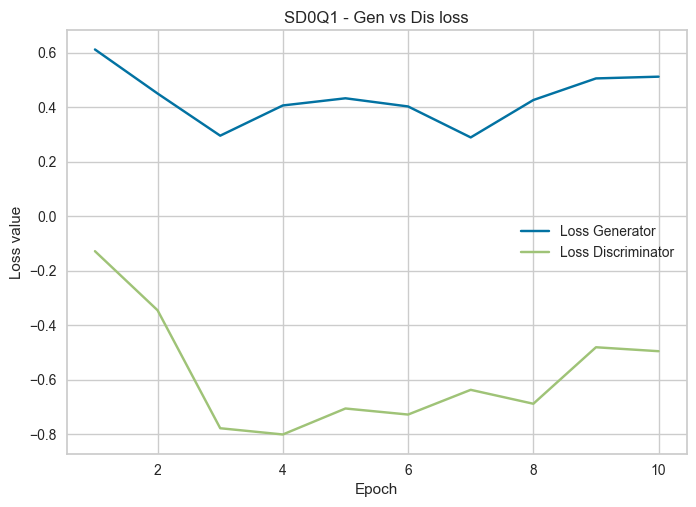

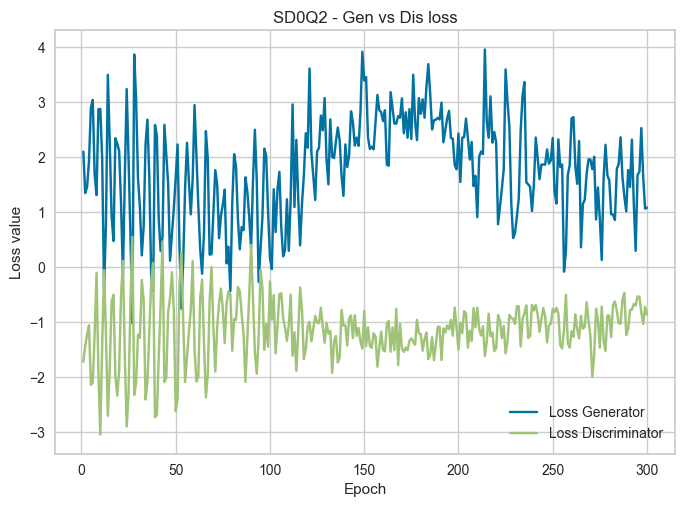

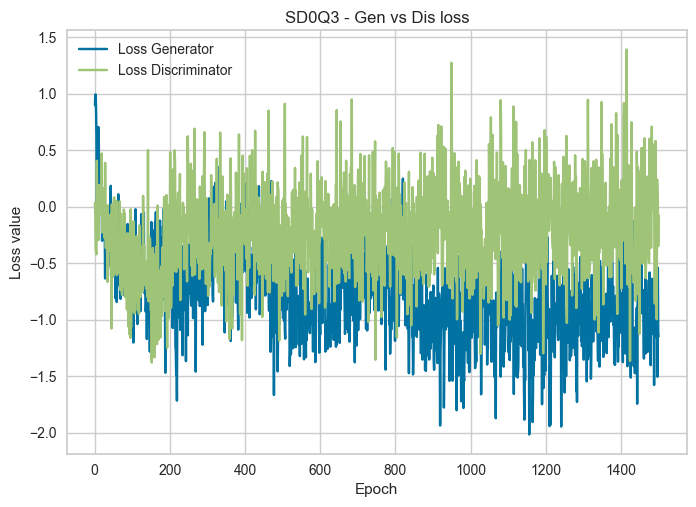

In [6]:
""" The Loss values captured from the cell above's standard output will 
be used to create the generator vs discriminator loss plots.
"""
loss_values = extract_loss_info_from_stdout(stdout_loss.stdout)
# Combine the loss values and save them
combined_loss_df = pd.concat(loss_values.values(), keys=loss_values.keys(), axis=0, ignore_index=False)
combined_loss_df = combined_loss_df.reset_index().rename(columns={'level_0': 'SDG'})
combined_loss_df.to_csv(f"{folders['data_dir']}combined_sdg_loss.csv", index=False)

for sdg_id in loss_values:
    fig = create_loss_plot(sdg_id, loss_values[sdg_id])
    # Save the plot to correct mlflow log
    run=mlflow.load_run_by_name(sdg_id)
    path=run.info.artifact_uri.replace("file:///", "")
    #save plot
    fig.savefig(f"{path}/{sdg_id}_loss_plot.png")
    #save data
    loss_values[sdg_id].to_csv(f"{path}/{sdg_id}.csv", index=False)
    

---

# Step 4: Create models with SD

In [7]:
import pandas as pd 
import os 
import sys 
import pickle
import re

from pycaret.classification import *
from pycaret.containers.models.classification import get_all_model_containers

from sklearn.metrics import (classification_report, 
                             roc_auc_score, 
                             matthews_corrcoef,
                             cohen_kappa_score)
sys.path.append('../src')
from utils import (getExperimentConfig, 
                   getPicklesFromDir, 
                   run_pycaret_setup, 
                   translate_model_name,
                   get_synthetic_filepaths_from_original_data_id,
                   convert_and_clean_dict)

from tuning_grids import Grids
from mlflow_manager import MLFlowManager

# Get global variables for the experiment
config = getExperimentConfig()
# Get folders
folders = config['folders']
# Load dataset specific settings (from the real-data)
dataset_settings = getPicklesFromDir(folders['settings_dir'])

In [ ]:
%%notify -m "Step 4: SD_models has finished!"

run_dataset = config['run_dataset']

for settings in dataset_settings:
        
    if run_dataset is not None and settings['meta']['id'] not in run_dataset:
        continue
        
    # update system_log name
    settings['setup_param']['system_log'] = folders['log_dir']+"Step4_SD"
    # disable saving train-test split data (to save space)
    settings['setup_param']['log_data'] = False
    
    # Get experiment logging
    experiment_name = f"{settings['meta']['id']}-{settings['meta']['name']}"
    mlflow = MLFlowManager(experiment_name)
    
    best_model_from_original_data = mlflow.get_best_model_hyperparameters()

    original_data = pd.read_csv(f"{folders['real_dir']}{settings['meta']['filename']}")
    y_test = original_data[settings['meta']['target']]
    x_test = original_data.drop(columns=[settings['meta']['target']])

    logg_tags = {'Dataset Type': 'synthetic'}
    mlflow.start_run('Synthetic data models', tags=logg_tags)
    
    synthetic_datasets = get_synthetic_filepaths_from_original_data_id(settings['meta']['id'])

    for sd_filename in synthetic_datasets:
        
        sd_id = os.path.splitext(sd_filename)[0]
        quality = re.findall('Q\d+', sd_id)[0]
        sd_path = folders['sd_dir']+sd_filename
        
        s = run_pycaret_setup(sd_path, settings['setup_param'])
        USI = s.get_config('USI')
        
        # Add custom tags to the logg, defining dataset type, and Id
        logg_tags = {
            'Dataset Type': 'synthetic',
            'Dataset ID': sd_id,
            'Quality': quality,
            'USI': USI
        }
        run_name = f"{sd_id}-models"
        mlflow.start_run(run_name, tags=logg_tags, nested=True)

        ########## Test hyper parameter tuning
        ########### Test the model with best performance from best original dataset ###########
        ml_model = best_model_from_original_data['model']
        hyperparameters = best_model_from_original_data['params']
        hyperparameters = convert_and_clean_dict(hyperparameters)
        model_name = f"Original_{sd_id}{translate_model_name(ml_model)}"


        # create & tune model
        #model = s.create_model(ml_model)

        #Quickfix for efficiency
        all_models = get_all_model_containers(s)
        model = all_models[ml_model].class_def(**hyperparameters)

        tuned_model = s.create_model(model)

        # get validation results
        val_df = s.pull()
        val_score = {}
        val_score['val_Accuracy'] = val_df['Accuracy']['Mean']
        val_score['val_F1-score'] = val_df['F1']['Mean']


        pred_model = s.predict_model(estimator=tuned_model, data=x_test)
        y_pred = pred_model['prediction_label']

        metrics =  classification_report(y_true=y_test, y_pred=y_pred, output_dict=True, digits=4)
        test_score = pd.DataFrame.from_dict(metrics).transpose()

        test_metrics = {
            "Accuracy": metrics['accuracy'],
            "F1-score": metrics['macro avg']['f1-score'],
            "MCC": matthews_corrcoef(y_true=y_test, y_pred=y_pred),
            "Kappa": cohen_kappa_score(y1=y_test, y2=y_pred)
        }

        # If there is a prediction_score in the from predict_model (sometimes there isn't)
        if 'prediction_score' in pred_model.columns:
            y_pred_score = pred_model['prediction_score']
            # If multiclass classification, set argument multi_class='one-vs-one'
            if original_data[settings['meta']['target']].nunique() > 2:
                m_class = 'ovo'
            else:
                m_class = 'raise'
            test_metrics['AUC'] = roc_auc_score(y_true=y_test, y_score=y_pred_score, multi_class=m_class)


        # log parameters     
        mlflow.log_params(tuned_model.get_params())
        # log performance
        mlflow.log_metric_report(test_metrics)
        mlflow.log_metrics(val_score)
        mlflow.log_score_report_to_html(val_df, "Validation")
        mlflow.log_score_report_to_html(test_score, "Test_score")
        # log model
        mlflow.log_model(model=tuned_model)
        # end logging run for the model
        mlflow.end_run()
        ########### End test hyper-param ###########
           
        # Start testing all models
        for ml_model in config['clf']['ml_models']:
            #start log run
            logg_tags['model']=ml_model
            model_name = f"{sd_id}-{translate_model_name(ml_model)}"
            mlflow.start_run(model_name, tags=logg_tags, nested=True)
            
            # create & tune model
            #model = s.create_model(ml_model)
            
            #Quickfix for efficiency
            all_models = get_all_model_containers(s)
            model = all_models[ml_model].class_def()
            # Get tuning grid
            tune_grid = Grids.get_tuning_grid(ml_model)
            
            # Is buggy, use default tuning by pycaret
            tuned_model = s.tune_model(model, **config['clf']['tuning_param'], custom_grid=tune_grid)
            # Old: tuned_model = s.tune_model(model, **config['clf']['tuning_param'])            
            
            # get validation results
            val_df = s.pull()
            val_score = {}
            val_score['val_Accuracy'] = val_df['Accuracy']['Mean']
            val_score['val_F1-score'] = val_df['F1']['Mean']


            pred_model = s.predict_model(estimator=tuned_model, data=x_test)
            y_pred = pred_model['prediction_label']

            metrics =  classification_report(y_true=y_test, y_pred=y_pred, output_dict=True, digits=4)
            test_score = pd.DataFrame.from_dict(metrics).transpose()
            
            test_metrics = {
                "Accuracy": metrics['accuracy'],
                "F1-score": metrics['macro avg']['f1-score'],
                "MCC": matthews_corrcoef(y_true=y_test, y_pred=y_pred),
                "Kappa": cohen_kappa_score(y1=y_test, y2=y_pred)
            }

            # If there is a prediction_score in the from predict_model (sometimes there isn't)
            if 'prediction_score' in pred_model.columns:
                y_pred_score = pred_model['prediction_score']
                # If multiclass classification, set argument multi_class='one-vs-one'
                if original_data[settings['meta']['target']].nunique() > 2:
                    m_class = 'ovo'
                else:
                    m_class = 'raise'
                test_metrics['AUC'] = roc_auc_score(y_true=y_test, y_score=y_pred_score, multi_class=m_class)


            # log parameters     
            mlflow.log_params(tuned_model.get_params())
            # log performance
            mlflow.log_metric_report(test_metrics)
            mlflow.log_metrics(val_score)
            mlflow.log_score_report_to_html(val_df, "Validation")
            mlflow.log_score_report_to_html(test_score, "Test_score")
            # log model
            mlflow.log_model(model=tuned_model)
            # end logging run for the model
            mlflow.end_run()
            
        # end logging run for SD_id
        #TODO: save best model for each sd_id-models
        # Save model details on the model with best accurracy under the the 'Original data models' run
        #best_run = mlflow.get_best_run_by_metric(metric_name='Accuracy')

        #mlflow.log_params(best_run.data.params)
        #mlflow.log_metrics(best_run.data.metrics)
        #mlflow.log_tag('model run name', best_run.data.tags['mlflow.runName'])
        #mlflow.log_tag('model', best_run.data.tags['model'])
        #mlflow.log_tag('model run id', best_run.info.run_id)
    
        mlflow.end_run()

    # end logging for the synthetic datasets based on original id
    mlflow.end_run()          

,Description,Value
0,Session id,799
1,Target,Outcome
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(614, 9)"
6,Transformed test set shape,"(154, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,None


Exception ignored in: <function FastMemory.__del__ at 0x000002AC9D8178B0>
Traceback (most recent call last):
  File "C:\Users\flore\miniconda3\envs\master\lib\site-packages\pycaret\internal\memory.py", line 458, in __del__
    self.reduce_size()
  File "C:\Users\flore\miniconda3\envs\master\lib\site-packages\pycaret\internal\memory.py", line 444, in reduce_size
    return super().reduce_size()
  File "C:\Users\flore\miniconda3\envs\master\lib\site-packages\joblib\memory.py", line 999, in reduce_size
    self.store_backend.reduce_store_size(self.bytes_limit)
  File "C:\Users\flore\miniconda3\envs\master\lib\site-packages\joblib\_store_backends.py", line 281, in reduce_store_size
    items_to_delete = self._get_items_to_delete(bytes_limit)
  File "C:\Users\flore\miniconda3\envs\master\lib\site-packages\joblib\_store_backends.py", line 300, in _get_items_to_delete
    items = self.get_items()
  File "C:\Users\flore\miniconda3\envs\master\lib\site-packages\joblib\_store_backends.py", line 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4677,0.4817,0.4138,0.4286,0.4211,-0.0712,-0.0712
1,0.4355,0.4493,0.4138,0.4000,0.4068,-0.1314,-0.1315
2,0.4839,0.4420,0.3103,0.4286,0.3600,-0.0542,-0.0562
3,0.6290,0.5831,0.5517,0.6154,0.5818,0.2503,0.2515
4,0.6393,0.6981,0.6071,0.6071,0.6071,0.2738,0.2738
5,0.4098,0.4383,0.3929,0.3667,0.3793,-0.1819,-0.1823
6,0.5738,0.5238,0.4286,0.5455,0.4800,0.1276,0.1303
7,0.5902,0.5795,0.5000,0.5600,0.5283,0.1680,0.1689
8,0.4098,0.3961,0.2857,0.3333,0.3077,-0.2013,-0.2031


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,06:13:11
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


---

# Step 5: Measure Population Fidelity (PF)

In [ ]:
import pandas as pd 
import sys
import os

sys.path.append('../src')
from PF_metrics import compute_all_pf_measures
from utils import (getExperimentConfig, 
                   getPicklesFromDir, 
                   get_synthetic_filepaths_from_original_data_id)

config = getExperimentConfig()
folders = config['folders']

settings = getPicklesFromDir(folders['settings_dir'])

In [ ]:
%%notify -m "Step 4: Measureing PF finished!"
pf_measure_columns = [
    'DatasetName',
    'pMSE',
    'pMSE_time',
    's_pMSE',
    's_pMSE_time',
    'Cluster_1',   # num of clusters = 1% of dataset_size
    'Cluster_1_time',   # num of clusters = 1% of dataset_size
    #'Cluster_5',     # num of clusters = 5% of dataset_size
    #'Cluster_10',    # num of clusters = 10% of dataset_size
    'BNLogLikelihood',
    'BNLogLikelihood_time',
    'GMLogLikelihood',
    'GMLogLikelihood_time',
    'ContinousKLDivergence',
    'ContinousKLDivergence_time',
    'DiscreteKLDivergence',
    'DiscreteKLDivergence_time',
    'KSComplement',
    'KSComplement_time',
    'CSTest',
    'CSTest_time',
    'CrossClassification', #Cross-classification 
    'CrossClassification_time', #Cross-classification 
]


result_df = pd.DataFrame(columns=pf_measure_columns)

for dataset_setting in settings:
    original_data = pd.read_csv(folders['real_dir']+dataset_setting['meta']['filename'])
    
    metadata = dataset_setting['meta']['meta_data']
    original_data_id = dataset_setting['meta']['id']
    
    synthetic_datasets = get_synthetic_filepaths_from_original_data_id(original_data_id)
    
    
    for sd_filename in synthetic_datasets:
        
        sd_id = os.path.splitext(sd_filename)[0]
        sd_path = folders['sd_dir']+sd_filename

        synthetic_data = pd.read_csv(sd_path)
        
        pf_measures = compute_all_pf_measures(original_data=original_data,
                                              synthetic_data=synthetic_data,
                                              metadata=metadata,
                                              SD_id=sd_id)
        
        result_df = pd.concat([result_df, pf_measures], axis=0, ignore_index=True)


# save the results
result_df.to_csv('../data/pf_measures.csv', index=False)
result_df.to_html('../data/pf_measures.html')

In [ ]:
import time
end_time = time.perf_counter()

timed = end_time-start_time

print(f"Experiment took {timed} seconds")
print(f"Which is {timed/60} minutes.")

#### TODO:
Need to fix some error with applying higher number of groups of clusters to the cluster analysis metric